In [76]:
'''CISC 452 Project 2020
Parkinson's Disease detection
Harry Kim 20047381

Do pip install imblearn for SMOTE, the rest are on Anaconda 
Also, my preprocessing is done all in one file. parkinsons.csv should be unprocessed csv file. 
'''
import pandas as pd
import numpy as np

df = pd.read_csv('parkinsons.csv')

In [77]:
import random
#my own train_test_split. Had to make this because there are multiple rows from same patient
df2=df.copy()

def train_test_split(df): 
    #change the name column so that its just patient's ID (there are 6 records each ID)
    for i,row in df.iterrows():
        df.at[i,'name'] = row['name'][9:12]

    #25% for testing 
    non_parkinson= df.loc[df['status'] == 0] #negative
    parkinson = df.loc[df['status'] == 1] #positive
    non_parkinson_list = list(non_parkinson['name'].unique())
    parkinson_list = list(parkinson['name'].unique())

    #randomly choose 2 patients from non parkinsons class for test(there are 8 total so 25%)
    aList = random.sample(non_parkinson_list,2)
    #get rid of them in the non_parkinson_lst so we can use it in y_train
    non_parkinson_list=[x for x in non_parkinson_list if x not in aList] 
    not_p = df[df['name'].isin(aList)]
    
    #23 patients with parkinson positive. We went with 6 since that's the closest to 25%
    aList = random.sample(parkinson_list,6) 
    parkinson_list=[x for x in parkinson_list if x not in aList] 
    p = df[df['name'].isin(aList)]

    #combining to make X,y test
    X_test = pd.concat([not_p,p])

    #For training set, use the remainder
    not_p = df[df['name'].isin(non_parkinson_list)]
    p = df[df['name'].isin(parkinson_list)]

    X_train = pd.concat([not_p,p])

    #Get y_test
    y_test = X_test['status'] 
    X_test = X_test.drop('status', axis = 1)

    #shuffle traning samples
    #X_train = X_train.sample(frac=1).reset_index(drop=True)
    y_train = X_train['status'] 
    X_train = X_train.drop('status', axis = 1)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df2)




In [78]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#i know its a sin to mess with the testing data after the split but i accidently formatted the train_test_split in a way that it has to take in the whole df... Only dropping, normalizing, oversampling done to the data.

def pre_process(X_train, X_test, y_train):
    X_train = X_train.drop('name', axis =1)
    X_test = X_test.drop('name', axis =1)

    #normalize data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    #not having enough parkinson positive samples hurt the training. Oversmaple the minority.
    sm = SMOTE()
    X_train, y_train= sm.fit_sample(X_train, y_train)

    return X_train, X_test, y_train

X_train, X_test, y_train = pre_process(X_train, X_test, y_train)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_validate

#BaseCase
def logReg(X_train,X_test,y_train,y_test):
    model = LogisticRegression(n_jobs = -1)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    print('score is ',metrics.accuracy_score(y_test,pred))
logReg(X_train,X_test,y_train,y_test)


score is  0.7346938775510204


In [80]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import metrics 

print(X_test.shape[1])
#preprocessing data for Neural Network 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
#input
model.add(LSTM(22, return_sequences = True, recurrent_dropout=0.1, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences = True, recurrent_dropout = 0.1))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences = False, recurrent_dropout=0.1))
model.add(Dropout(0.5))
#output
model.add(Dense(1, activation = 'tanh'))
model.compile(loss='squared_hinge',optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(X_train,y_train,epochs = 100)
scores = model.evaluate(X_test, y_test)
print('testing accuracy',scores[1])

22
Epoch 1/100
7/7 [==============================] - 0s 42ms/step - loss: 0.9220 - accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 0.7921 - accuracy: 0.5545
Epoch 3/100
7/7 [==============================] - 0s 42ms/step - loss: 0.6924 - accuracy: 0.6364
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6343 - accuracy: 0.6955
Epoch 5/100
7/7 [==============================] - 0s 46ms/step - loss: 0.6130 - accuracy: 0.7455
Epoch 6/100
7/7 [==============================] - 0s 45ms/step - loss: 0.5899 - accuracy: 0.7545
Epoch 7/100
7/7 [==============================] - 0s 46ms/step - loss: 0.5698 - accuracy: 0.7455
Epoch 8/100
7/7 [==============================] - 0s 46ms/step - loss: 0.5862 - accuracy: 0.7500
Epoch 9/100
7/7 [==============================] - 0s 44ms/step - loss: 0.5535 - accuracy: 0.7636
Epoch 10/100
7/7 [==============================] - 0s 49ms/step - loss: 0.5420 - accuracy: 0.7682
Epoch 11/100
7/7

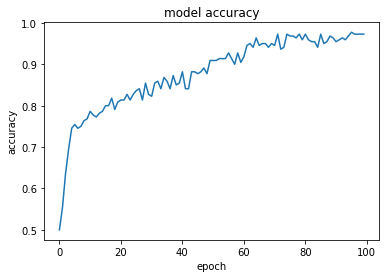

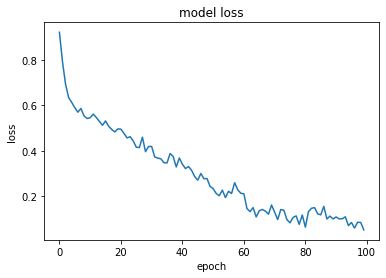

In [81]:
import matplotlib.pyplot as plt

#Graphing out performance
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

yes
-0.9312849 0
-0.99848354 0
-0.99886394 0
-0.3567163 0
-0.9957113 0
-0.9931886 0
-0.9842446 0
0.9993228 0
-0.99404866 0
-0.98583287 0
0.4473842 0
0.68250334 0
0.9999982 1
0.9999987 1
0.99999875 1
0.9999986 1
0.9999988 1
0.9999984 1
0.9997218 1
0.9999979 1
0.9921821 1
0.70680285 1
0.9909635 1
0.94560957 1
0.98928463 1
0.9980678 1
0.81199634 1
0.99925053 1
-0.14199202 1
-0.69334567 1
0.99999845 1
0.99999785 1
0.99999744 1
0.99999845 1
0.9999989 1
0.9999982 1
0.9999986 1
0.9999979 1
0.99996054 1
0.93364257 1
0.9946565 1
0.9992764 1
0.9800669 1
-0.6303416 1
-0.30308262 1
-0.80177414 1
-0.8780248 1
0.99089354 1
-0.8688519 1
recall is 0.8108108108108109
precision is 0.9090909090909091
auc is 0.7804054054054055
accuracy is 0.7959183673469388
confusion matrix [[ 9  3]
 [ 7 30]]


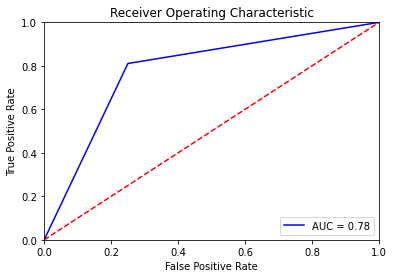

In [95]:
#model evaluation
from keras.utils.vis_utils import plot_model
from sklearn import metrics 

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print('yes')
#model returns  tanh ranging from -1 to 1 and does not work with sklearn metrics. Change it to binary
y_pred = model.predict(X_test)
yp = []
for i in range(len(y_pred)):
    if y_pred[i][0] > 0:
        yp.append(1)
    else:
        yp.append(0)

y_test = list(y_test)
for i in range(len(y_pred)):
    print(y_pred[i][0],y_test[i])

from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
print('recall is',recall_score(y_test, yp))
print('precision is',precision_score(y_test,yp))
print('auc is', roc_auc_score(y_test, yp))
print('accuracy is', accuracy_score(y_test, yp))
print('confusion matrix',metrics.confusion_matrix(y_test,yp))
fpr, tpr, threshold = metrics.roc_curve(y_test, yp)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [83]:
# import statistics
# #Bootleg Cross Valdiation 
# cv_acc = []

# for i in range(5):
#     #Does not garuntee to be new samples each time but with large enough iterations, it should even out
#     df2 = df.copy()
#     X_train, X_test, y_train, y_test = train_test_split(df2)
#     X_train, X_test, y_train = pre_process(X_train, X_test, y_train)

#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#     #just run the model again, its the same thing
#     model = Sequential()
#     #input
#     model.add(LSTM(22, return_sequences = True, recurrent_dropout=0.1, input_shape=(X_train.shape[1],1)))
#     model.add(Dropout(0.5))
#     model.add(LSTM(50, return_sequences = True, recurrent_dropout = 0.1))
#     model.add(Dropout(0.5))
#     model.add(LSTM(50,return_sequences = False, recurrent_dropout=0.1))
#     model.add(Dropout(0.5))
#     #output
#     model.add(Dense(1, activation = 'tanh'))
#     model.compile(loss='squared_hinge',optimizer = 'Adam', metrics = ['accuracy'])
#     history = model.fit(X_train,y_train,epochs = 100)
#     scores = model.evaluate(X_test, y_test)
#     print(scores[1])
#     cv_acc.append(scores[1])

# print('cross validation results :',cv_acc)
# print('Cross Validation average is:',statistics.mean(cv_acc))